warnings: <br>
1. pillow 5.2.0 is the only version that loads the tiff files correctly! <br>
2. For nn.Identity() to work, you need pytorch > 1.0.0 (not sure by how much). However, with 1.3.1 fastai stops working well. 

In [3]:
# check for OS and set params accordingly. 
import platform
machine_OS = platform.system()
if machine_OS == 'Windows':
    batch_size = 1 
    num_workers = 0
elif machine_OS == 'Linux':
    batch_size = 1 
    num_workers = 16 
print(machine_OS, 'OS. Batchsize:', batch_size, ', Num of workers:', num_workers)

# set cuda engine and get debugging information
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0' 

# import packages:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import os
from tqdm import tqdm_notebook
# import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils

from torchvision import transforms

import torch.nn.functional as F

from IPython.display import display
from pathlib import Path


from torchsummary import summary
from m_network_architectures import *

Linux OS. Batchsize: 1 , Num of workers: 16


# data loading

In [4]:
BaseFolder = Path.cwd()
DataFolder = BaseFolder/'Data'

x_train_dir = DataFolder/'training'/'images'
y_train_dir = DataFolder/'training'/'1st_manual'
screen_train_dir = DataFolder/'training'/'mask'

# x_test_dir = os.path.join(DATA_DIR, 'test')
# y_test_dir = os.path.join(DATA_DIR, 'testannot')

# Custum dataloader

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from m_dataset_aux_functions import *

## Making a Map-style dataset

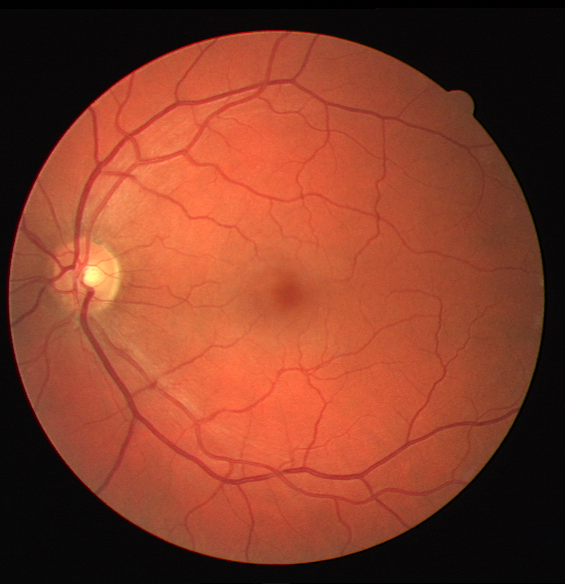

In [6]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
im = Image.open(x_images_paths[0])
display(im)

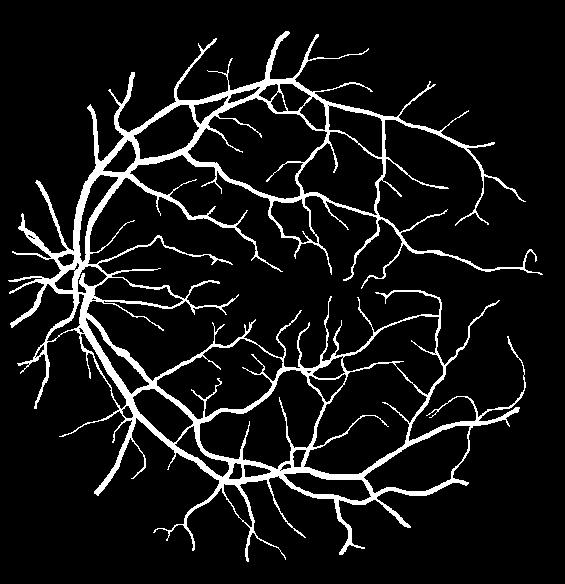

In [5]:
images_dir = x_train_dir
masks_dir = y_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
y_masks_paths = [str(get_mask_path(image_path, masks_dir).absolute()) for 
                         image_path in images_dir.glob('*.tif')]
im = Image.open(y_masks_paths[0])
display(im)
tmp_im = np.array(im)

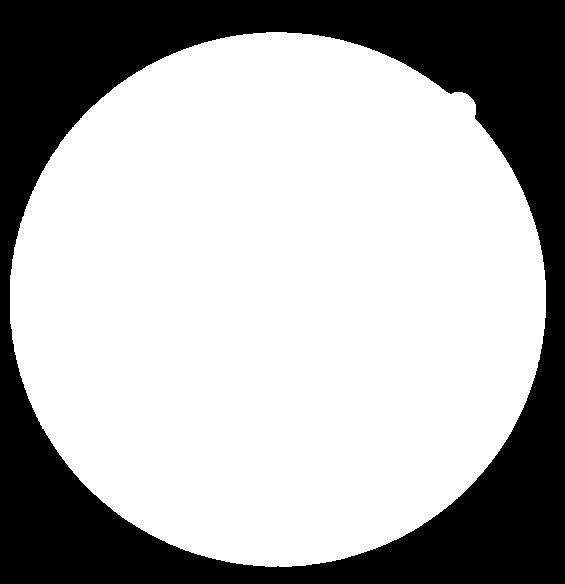

In [7]:
images_dir = x_train_dir
x_images_paths = [str(image_path.absolute()) for image_path in images_dir.glob('*.tif')]
tmp_path = get_screen_path(Path(x_images_paths[0]), screen_train_dir)
im_mask =  Image.open(str(tmp_path))
display(im_mask)

In [7]:
from m_dataset_aux_functions import *

In [8]:
interpolation = 0 # only valid if image size is defined. 
ImageSize = None # makes the image a square. None will maintain the original size
MaxTrainingSetSize = 1
ImageNetNorm = False
(trainDataset, vldtnDataset) = MakeDatasets(x_train_dir, screen_train_dir, y_train_dir, 
                                            MaxTrainingSetSize = MaxTrainingSetSize, size = ImageSize, 
                                            interpolation = interpolation, ImageNetNorm=ImageNetNorm)
print('Training set size: {}, Validation set size: {}'.format(len(trainDataset), len(vldtnDataset)))

Training set size: 1, Validation set size: 1


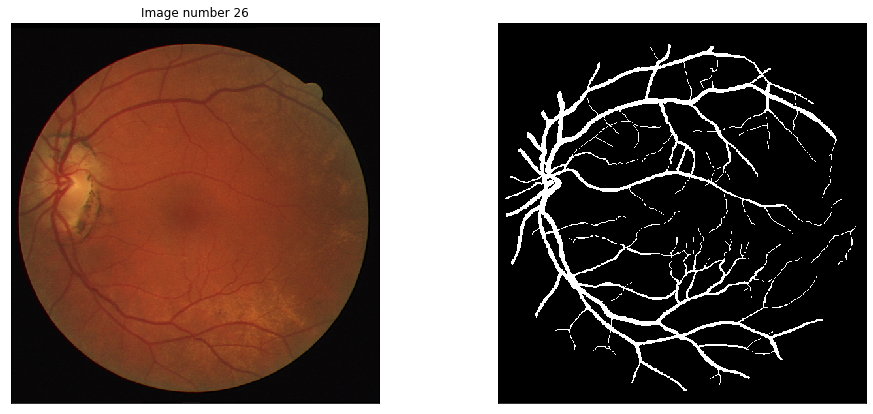

In [9]:
visualizeDataset(trainDataset, UnNormalize = ImageNetNorm)

# Create model and train

In [10]:
from m_network_architectures import *
from m_dataset_aux_functions import *

In [11]:
train_loader = DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
vldtn_loader = DataLoader(dataset = vldtnDataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [42]:
del model
torch.cuda.empty_cache()
import gc
gc.collect()

3184

Traceback (most recent call last):
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(sel

In [17]:
with torch.no_grad():
    output = torch.tensor(np.random.random(5000), requires_grad = True)
    target = torch.tensor(np.random.randint(0,2,5000), requires_grad = False)
    del m_loss_functionals
    import m_loss_functionals
    criterion = m_loss_functionals.FocalLoss()
    loss = criterion(output, target, alpha = torch.tensor(.2), gamma = 2.)
    print(loss)
    del loss

NameError: name 'm_loss_functionals' is not defined

In [19]:
del m_loss_functionals
import m_loss_functionals
criterion = m_loss_functionals.FocalLoss()
loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)

NameError: name 'output' is not defined

In [16]:
import m_loss_functionals


In [43]:
import m_loss_functionals
# model = UNet(n_class=1).cuda()
# model = UNet_V2(n_class=1).cuda()
# model = UNet_V3(n_class=1, bn = False, freeze=False).cuda()
model = UNet_V4(n_class=1, bn = True).cuda()

# criterion = nn.BCEWithLogitsLoss(torch.tensor(20))
# criterion = m_loss_functionals.DiceLoss()
# criterion = m_loss_functionals.FocalLoss(alpha=torch.tensor(0.9), gamma=2)
# criterion = m_loss_functionals.WCE()

# criterion = nn.CrossEntropyLoss()

In [29]:
# model = torch.load(str(BaseFolder / 'Model640Intrpl_dice_1bs_50Epochs.pth'))

In [46]:
criterion = m_loss_functionals.FocalLoss(alpha=torch.tensor(0.6), gamma=1) 
metric = m_loss_functionals.DiceLoss()

In [61]:
criterion.alpha = torch.tensor(0.7)
criterion.gamma = 1.5

In [44]:
criterion = m_loss_functionals.DiceLoss()

In [62]:
# check size 
lr_SGD_Dice = 5e-12
lr = lr_SGD_Dice
optimizer = torch.optim.SGD(model.parameters(), weight_decay=1e-4, lr = lr, momentum=0.9) # works well
# optimizer = torch.optim.Adam(model.parameters(), weight_decay=1e-4, lr = lr)
losses = list()
vldtn_losses = list()
model.train()
for epoch in range(200): 
    t0 = time.time()
    Epoch_losses = list()
    model.train()         
    for ii, (data, target, screen) in enumerate(train_loader):    
        data, target, screen = data.cuda(), target.cuda(), screen.cuda() # please do so before constructing optimizers for it
        optimizer.zero_grad()
        output = model(data)  
#         loss = criterion(output, target, screen, alpha = torch.tensor(1.), gamma = 2.)
        loss = criterion(output, target, screen)*(1 + 20 * metric(output, target, screen))
#         loss = criterion(output, target, screen)

        with torch.no_grad():
            metric_val = metric(output, target, screen)
        loss.backward()
        optimizer.step()
        Epoch_losses.append(loss.item())
        del loss
        
    losses.append(np.mean(Epoch_losses))
    # run validation        
    val_Epoch_mean, metric_epoch_mean = eval_epoch_vldtn_loss(model, vldtn_loader, criterion, metric=metric)
    vldtn_losses.append(val_Epoch_mean)
    
    adjust_learning_rate(lr, optimizer, epoch, ratio = 0.5, epochNumForDecrease = 50)
    print('Epoch: {} - Loss: {:.4f} - Metric: {:.3f} , Validation: {:.4f}, Runtime: {:.2f} [s]'.format(epoch + 1, 
                                                                              np.mean(Epoch_losses),
                                                                                metric_val.item(),
                                                                              val_Epoch_mean,
                                                                              time.time()- t0))
    del metric_val

New learning rate:  5e-12
Epoch: 1 - Loss: 344512.8750 - Metric: 0.218 , Validation: 2183587.7500, Runtime: 2.40 [s]
Epoch: 2 - Loss: 344496.9062 - Metric: 0.218 , Validation: 2183593.0000, Runtime: 2.27 [s]
Epoch: 3 - Loss: 344466.3438 - Metric: 0.218 , Validation: 2183614.7500, Runtime: 2.25 [s]
Epoch: 4 - Loss: 344422.9375 - Metric: 0.218 , Validation: 2183651.5000, Runtime: 2.26 [s]
Epoch: 5 - Loss: 344367.8438 - Metric: 0.218 , Validation: 2183704.5000, Runtime: 2.24 [s]
Epoch: 6 - Loss: 344302.6562 - Metric: 0.218 , Validation: 2183772.7500, Runtime: 2.28 [s]
Epoch: 7 - Loss: 344227.9375 - Metric: 0.218 , Validation: 2183854.2500, Runtime: 2.25 [s]
Epoch: 8 - Loss: 344145.1250 - Metric: 0.218 , Validation: 2183950.7500, Runtime: 2.29 [s]
Epoch: 9 - Loss: 344055.0000 - Metric: 0.218 , Validation: 2184061.5000, Runtime: 2.25 [s]
Epoch: 10 - Loss: 343958.5000 - Metric: 0.218 , Validation: 2184184.5000, Runtime: 2.26 [s]
Epoch: 11 - Loss: 343856.1562 - Metric: 0.218 , Validation: 218

KeyboardInterrupt: 

In [21]:
from torchsummary import summary
from m_network_architectures import *

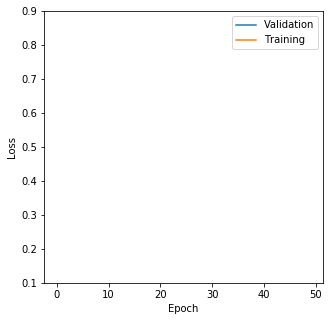

In [22]:
fig, ax = plt.subplots(1, figsize = (5,5))
ax.plot(vldtn_losses, label = 'Validation')
ax.plot(losses, label = 'Training')
ax.legend();
ax.set(xlabel = 'Epoch', ylabel = 'Loss', ylim = [0.1,0.9]);

In [52]:
def VisulaizePrediction(model, dataloader, ind_in_batch = 0, threshold = 0.5):
    ind = ind_in_batch
    mn = threshold
    with torch.no_grad():
        model.eval()
        val_Epoch_losses = list()
        for ii, (data, target, screen) in enumerate(dataloader): 
            break
        data, target, screen = data.cuda(), target.cuda(), screen.cuda()
        output = model(data) 
        
        fig, ax = plt.subplots(1,2, figsize = (20,10))
        predicted = torch.sigmoid(output[ind,0,:,:]).cpu().detach().numpy()
        screen_numpy = screen[ind,0,:,:].cpu().detach().numpy()
        
        predicted[screen_numpy < 0.8] = 0
        predicted[predicted > mn] = 1
        predicted[predicted < mn] = 0
#         predicted[predicted > mn] = 1
        t_array = target[ind,0,:,:].cpu().detach().numpy()
        ax[0].imshow(predicted, cmap = 'gray')
        ax[1].imshow(t_array, cmap = 'gray')

Traceback (most recent call last):
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/opt/anaconda3/envs/torchgpu/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


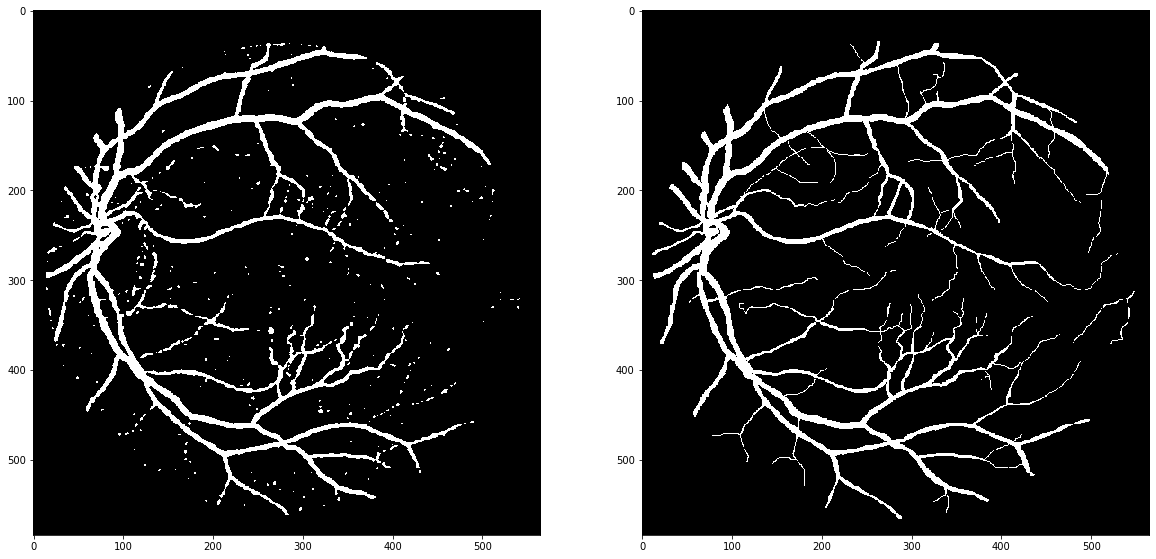

In [59]:
VisulaizePrediction(model, train_loader, ind_in_batch = 0, threshold = 0.5)

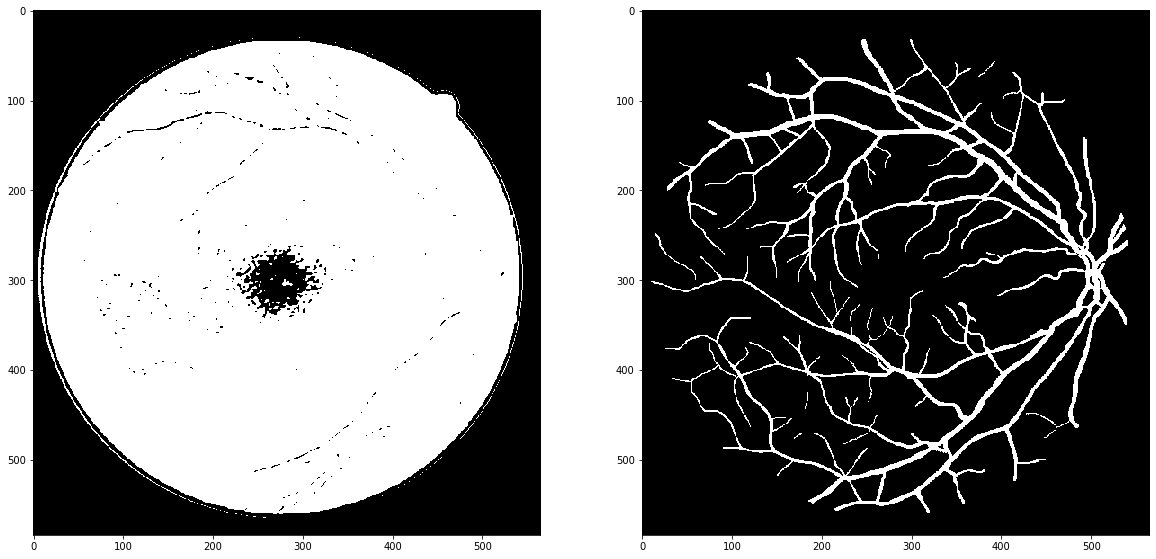

In [60]:
VisulaizePrediction(model, vldtn_loader, ind_in_batch = 0, threshold = 0.5)

In [46]:
torch.save(model, str(BaseFolder / 'ModelOrg_UNet4_dicePlusfocla_.pth'))

In [ ]:
! sudo shutdown -h now

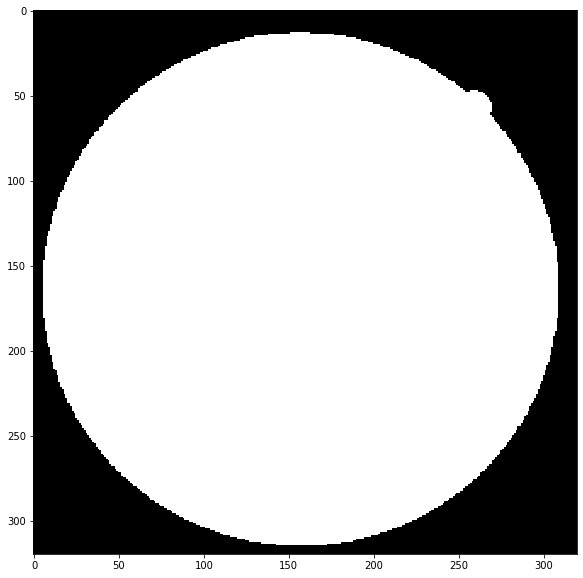

In [23]:
plt.figure(figsize=(10,10))
if batch_size>1: 
#     plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
    plt.imshow(screen[0].squeeze().cpu().detach().numpy(), cmap='gray')
else: 
    plt.imshow(output[0].squeeze().cpu().detach().numpy(), cmap='gray')
# plt.imshow(screen.squeeze().cpu().detach().numpy(), cmap='gray')

In [40]:
torch.save(model, str(BaseFolder / 'Model320NoIntrpl_dice_200Epochs.pth'))

/opt/anaconda3/envs/torchgpu/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
# torch.save(model, str(BaseFolder / 'Model320Bilinear.pth'))

In [29]:
x_test_dir = DataFolder/'test'/'images'

In [41]:
test_dataset = Dataset(
    x_train_dir, 
    screen_train_dir,
    classes=['yes'],
)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


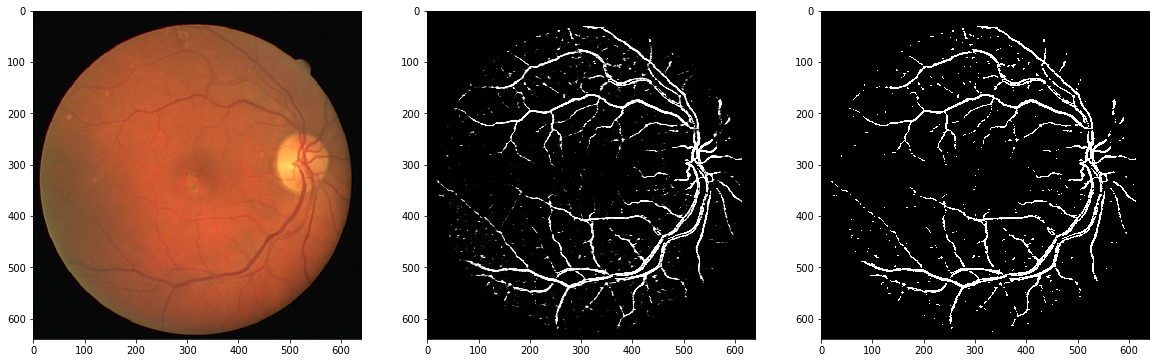

In [42]:
ind = 4
with torch.no_grad():
    fig, ax = plt.subplots(1,3, figsize = (20,8))

    x = test_dataset[ind][0].unsqueeze(0)
    o = model(x.cuda())
    original_image = x.cpu().detach().numpy()
    original_image = np.transpose(original_image[0], axes = [1,2,0])
    original_image = original_image * std + mean
    output_image = o.cpu().detach().numpy() 
    output_image = np.squeeze(output_image)
    output_image = 1/(1 + np.exp(-output_image)) 
    # mn = np.mean(output_image)*5
    mn = 0.5
    output_image_thresh = np.copy(output_image)
    output_image_thresh[output_image<mn] = 0
    output_image_thresh[output_image>mn] = 1
    ax[0].imshow(original_image)
    ax[1].imshow(output_image, cmap = 'gray')
    ax[2].imshow(output_image_thresh, cmap = 'gray')

TypeError: Invalid shape (2, 480, 480) for image data

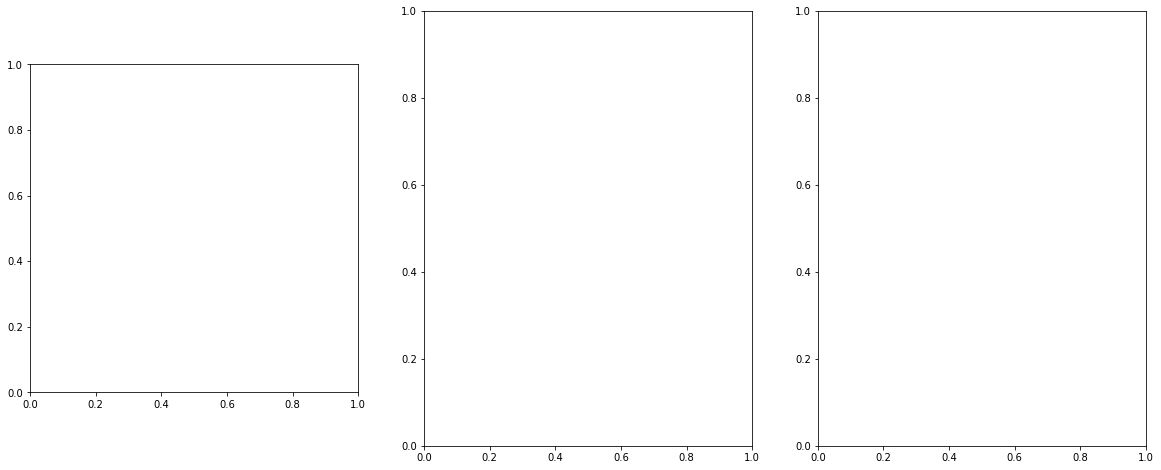

In [131]:
# if training over one bs = 1
fig, ax = plt.subplots(1,3, figsize = (20,8))
# x = augmented_dataset[0][0].unsqueeze(0)
# o = model(x.cuda())  
# tmp2 = o.cpu().detach().numpy() * (-1)
tmp2 = output.cpu().detach().numpy() 
tmp = np.copy(tmp2)
tmp3 = np.copy(tmp2)
mn = np.mean(tmp)*0.05
tmp3[tmp<mn] = 0
tmp3[tmp>mn] = 1
ax[0].imshow(np.squeeze(tmp3), cmap = 'binary_r')

target_numpy = target.cpu().detach().numpy()
ax[1].imshow(np.squeeze(target_numpy), cmap = 'binary_r')
ax[2].imshow(np.squeeze(tmp2), cmap = 'binary_r')

## Not figuring out things with loss functions

In [605]:
def WCE(output, target, weight = torch.tensor(1)):
    """My custom WEIGHTED Cross Entropy loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,inf]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    """
    output_clone = output.detach().clone()
    eps=torch.tensor(1e-21)
    return -(weight * target * F.logsigmoid(output_clone) + (1-target) * F.logsigmoid(1 - output_clone)).sum()
    # return -(weight * target * logSigmoid(output) + (1-target) * logSigmoid(1 - output)).sum()

In [604]:
def focal_loss(output, target, weight = torch.tensor(1)):
    """My custom Focal loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,1]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    See Lar's Blog on losses. 
    """
    

In [603]:
def BCE(output, target, weight = torch.tensor(1)):
    """My custom Balanced Cross Entropy loss function. It first runs the output through a Sigmoid, then computes the
    cross entropy. Weight is in range [0,1]. To decrease the number of false negatives, use a large weight. 
    To decrease the number flase positives, set to small. 
    It is not like BCE binary cross entropy:
    https://discuss.pytorch.org/t/weights-in-bcewithlogitsloss/27452/10
    https://discuss.pytorch.org/t/confusing-error-using-bcewithlogitsloss-with-weighted-loss/42435
    """
    eps=0
    output_clone = output.detach().clone()
    # output_clone = Sigmoid(output_clone)
    return -(weight * target * F.logsigmoid(output_clone + eps) +  (1-weight) * (1-target) * F.logsigmoid(1 - output_clone + eps)).sum()

In [632]:
weight = torch.tensor(1)
output = 1* torch.randn(3)
target = torch.empty(3).random_(2)
criterion = nn.BCEWithLogitsLoss(weight=weight, reduction='sum')
print(criterion(output, target))
print(WCE(output, target, weight = weight))
print(binary_cross_entropy_with_logits(output, target, weight=weight, reduction='sum'))
print(output, target)

tensor(2.0488)
tensor(1.6132)
tensor(2.0488)
tensor([-0.9652, -0.2209, -1.6723]) tensor([1., 0., 0.])


In [376]:
from torch.nn.functional import binary_cross_entropy_with_logits

In [ ]:
binary_cross_entropy_with_logits()

tensor(1.0091)